# Digit Recognition with LeNet-5
Before running your code, make sure you are working on a GPU. If not, click Runtime -> Change runtime type -> Hardware accelerator (set this to GPU). 
## Import libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. More details can be found in http://yann.lecun.com/exdb/mnist/. We can use pytorch to download it from LeCun's website and get the train and test sets ready. 

In [2]:
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = MNIST('./data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In Pytorch, every image should be transformed into a tensor (C,H,W) where C is channel number, H is height and W is width. After putting images into minibatches, a minibatch shoude be a tensor (N,C,H,W) where N is batchsize.

In [3]:
print('Single sample size')
print(data_train[0][0].shape)
minibatch = next(iter(data_train_loader))
images = minibatch[0]
labels = minibatch[1]
print('Batched sample size')
print(images.shape)


Single sample size
torch.Size([1, 32, 32])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Batched sample size
torch.Size([256, 1, 32, 32])


Visualize first 4 images and their labels in the training set.


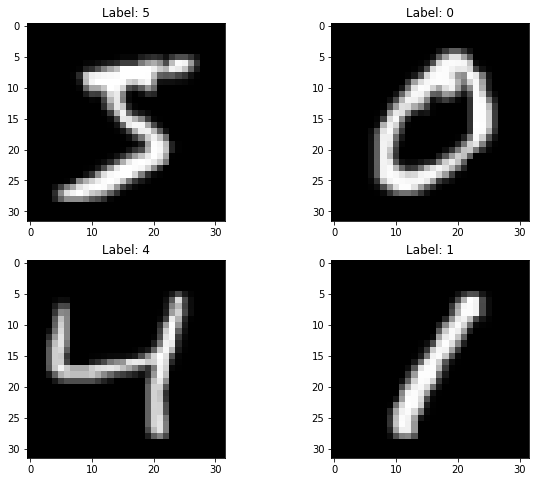

In [4]:
f = plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(data_train[0][0][0],cmap='gray')
plt.title('Label: {}'.format(data_train[0][1]))
plt.subplot(2,2,2)
plt.imshow(data_train[1][0][0],cmap='gray')
plt.title('Label: {}'.format(data_train[1][1]))
plt.subplot(2,2,3)
plt.imshow(data_train[2][0][0],cmap='gray')
plt.title('Label: {}'.format(data_train[2][1]))
plt.subplot(2,2,4)
plt.imshow(data_train[3][0][0],cmap='gray')
plt.title('Label: {}'.format(data_train[3][1]))
plt.show()

## LeNet-5
For a better performance, we change the activation function from Tanh to ReLU. We also change the original average pooling to max pooling. You can follow the description below to implement your LeNet-5 network.

In [65]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    ReLU
    S2 - 6@14x14 (2x2 kernel, stride 2) MaxPool Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    ReLU
    S4 - 16@5x5 (2x2 kernel, stride 2) MaxPool Subsampling
    C5 - 120@1x1 (5x5 kernel)
    ReLU
    F6 - 120 (Input) & 84 (Output)
    ReLU
    F7 - 84 (Input) & 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            #nn.Conv2d(in_channels=6, out_channels=6, kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=2, stride=2),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            #nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=2, stride=2),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU()
        )
        self.convnet.apply(self._weights_init_kaiming)
        self.fc = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
        self.fc.apply(self._weights_init_kaiming)

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output
    
    def _weights_init_kaiming(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data) 
        elif classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


In [66]:
lenet = LeNet5()
print(lenet.convnet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
)


In [67]:
print(lenet.fc)

Sequential(
  (0): Linear(in_features=120, out_features=84, bias=True)
  (1): ReLU()
  (2): Linear(in_features=84, out_features=10, bias=True)
)


## Train your network
1. We have to define a loss function. In pytorch, ```nn.CrossEntropyLoss()``` combines the softmax and cross entropy loss function.

2. We also have to define an optimizer. Here, we use a SGD (Stochastic Gradient Descent) with an initial learning rate 0.002 and a momentum 0.9.

3. We need a scheduler which decrease the initial learning rate by 0.1 at the 20th epoch. 

4. We need to write a train function, in which we use optimizer to update parameters in out network to minimize the loss function.

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=0.002, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=20)

In [69]:
lenet = lenet.to('cuda')
def train(maxepoch):
    lenet.train()
    for epoch in range(maxepoch):
        for i, (images, labels) in enumerate(data_train_loader):
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            optimizer.zero_grad()

            output = lenet(images)

            loss = criterion(output, labels)

            if i % 10 == 0:
                print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

            loss.backward()
            optimizer.step()
        scheduler.step()
    print('Finished.')

In [70]:
train(40)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train - Epoch 0, Batch: 0, Loss: 2.637451
Train - Epoch 0, Batch: 10, Loss: 2.353137
Train - Epoch 0, Batch: 20, Loss: 2.203272
Train - Epoch 0, Batch: 30, Loss: 2.103532
Train - Epoch 0, Batch: 40, Loss: 1.967164
Train - Epoch 0, Batch: 50, Loss: 1.847014
Train - Epoch 0, Batch: 60, Loss: 1.556440
Train - Epoch 0, Batch: 70, Loss: 1.220781
Train - Epoch 0, Batch: 80, Loss: 0.987281
Train - Epoch 0, Batch: 90, Loss: 0.787023
Train - Epoch 0, Batch: 100, Loss: 0.621607
Train - Epoch 0, Batch: 110, Loss: 0.595245
Train - Epoch 0, Batch: 120, Loss: 0.627958
Train - Epoch 0, Batch: 130, Loss: 0.502004
Train - Epoch 0, Batch: 140, Loss: 0.568895
Train - Epoch 0, Batch: 150, Loss: 0.479557
Train - Epoch 0, Batch: 160, Loss: 0.491034
Train - Epoch 0, Batch: 170, Loss: 0.410727
Train - Epoch 0, Batch: 180, Loss: 0.408123
Train - Epoch 0, Batch: 190, Loss: 0.347900
Train - Epoch 0, Batch: 200, Loss: 0.289498
Train - Epoch 0, Batch: 210, Loss: 0.305629
Train - Epoch 0, Batch: 220, Loss: 0.227230

## Test your network

In [71]:
def test():
    lenet.eval()
    total_correct = 0
    for i, (images, labels) in enumerate(data_test_loader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        output = lenet(images)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
    print('Accuracy: %f' % (float(total_correct) / len(data_test)))

You are supposed to get an accuracy > 0.98 in the test set.

In [72]:
test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.981500


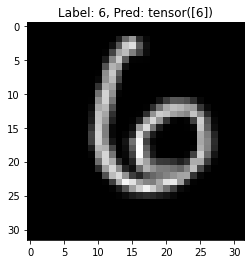

In [73]:
def visualize(idx):
    lenet.eval()
    image = data_test[idx][0].unsqueeze(0).to('cuda')
    label = data_test[idx][1]
    output = lenet(image)
    pred = output.detach().max(1)[1].cpu()
    plt.imshow(image[0][0].cpu(),cmap='gray')
    plt.title('Label: {}, Pred: {}'.format(label, pred))
visualize(100)